# Jaccard en folio

In [1]:
import os
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',900)

Cargamos la base

In [2]:
fname = './datos/cortes/w18/enasama_2024W18_0429_0505.pkl'
df_w18 = pd.read_pickle(fname)

In [3]:
df_w18.folio

0        161020001080002116003009
1        161020001080002116003009
2        161020001080002616003005
3        161020001176200216003004
4        161020001176200216003004
                   ...           
36064    240420001012900124004401
36065    240420001012900124004402
36066    240420001012900124004402
36067    240420001012900324004401
36068    240420001012900324004401
Name: folio, Length: 36069, dtype: object

In [4]:
entidad = df_w18[df_w18.entidad=='Aguascalientes']

## Índice de Jaccard

El índice de Jacard se calcula como y mide el grado de similitud entre dos conjuntos

$$
J(a,b) = \frac {|a\cap b|} {|a \cup b|}
$$

Específicamente mide el tamaño de la intersección de símbolos de la cadena a y b respecto de unión de símbolos.Si los conjuntos a y b son iguales entonces el índice es 0 y si son muy diferentes entonces el resultado tiende a 1.

Se puede hacer directamente con las cadenas pero lo vamos a intentar haciendo n-gramas.

In [5]:
def ngramas(c, n=3):
    """
    Convierte una cadena c en paquetes de 
    n-gramas
    
    - Parameters:
        c: cadena a dividir
        n: tamaño del n-garma
    
    - Returns:
        Lista con cadena c dividia en n-gramas
    """
    tr = [c[i:i+n] for i in range(len(c)-n+1)]
    return tr

def jaccard(a,b):
    """
    Índice de Jaccard entre a y b
    
    - Parameters:
        a y b: Listas de objeteos
    
    - Returns:
        Float con índice de jaccard
    """
    union = set(a).union(set(b))
    inter = set(a).intersection(set(b))
    return len(inter) / len(union)

In [6]:
folio1 = entidad.folio.iloc[0]
ngramas(folio1)

['010',
 '100',
 '001',
 '010',
 '100',
 '000',
 '000',
 '001',
 '019',
 '193',
 '937',
 '371',
 '719',
 '190',
 '900',
 '001',
 '010',
 '100',
 '001',
 '012',
 '120',
 '206']

In [7]:
folio1 = entidad.folio.iloc[0]
folio2 = entidad.folio.iloc[2]

jaccard(ngramas(folio1), ngramas(folio2)), folio1, folio2

(0.75, '010010000193719001001206', '010010000193719001001211')

In [8]:
folio1  = entidad.folio.iloc[0]
folio2  = entidad.folio.iloc[1]
folio3  = entidad.folio.iloc[2]
folio4  = entidad.folio.iloc[3]
folio5  = entidad.folio.iloc[4]
folio6  = entidad.folio.iloc[5]
folio7  = entidad.folio.iloc[6]
folio8  = entidad.folio.iloc[7]
folio9  = entidad.folio.iloc[8]
folio10 = entidad.folio.iloc[9]
folio11 = entidad.folio.iloc[10]
folio12 = entidad.folio.iloc[11]

In [9]:
M = np.zeros((len(entidad),len(entidad)))
for i in range(M.shape[0]):
    folio_i = entidad.folio.iloc[i]
    for j in range(M.shape[1]):
        folio_j = entidad.folio.iloc[j]
        M[i,j] = jaccard(ngramas(folio_i), ngramas(folio_j))

In [10]:
M

array([[1.        , 1.        , 0.75      , ..., 0.18181818, 0.16666667,
        0.18181818],
       [1.        , 1.        , 0.75      , ..., 0.18181818, 0.16666667,
        0.18181818],
       [0.75      , 0.75      , 1.        , ..., 0.18181818, 0.16666667,
        0.18181818],
       ...,
       [0.18181818, 0.18181818, 0.18181818, ..., 1.        , 0.73333333,
        0.84615385],
       [0.16666667, 0.16666667, 0.16666667, ..., 0.73333333, 1.        ,
        0.73333333],
       [0.18181818, 0.18181818, 0.18181818, ..., 0.84615385, 0.73333333,
        1.        ]])

## Vector de características

In [11]:
from itertools import product

In [24]:
class vector_cadena:
    """
    Clase para vectorizar a partir de los n-gramas
    """
    #------------------------------------
    def __init__(self, lista, metodo='posicion', tam=2):
        """
        Constructor: el diccionario es una lista de letras permitidas 
        El feature space es un arreglo con todos los posibles n-gramas 
        """
        assert (metodo in ['frec','posicion','ambos'])
        
        self.conjunto      = lista.lower()
        self.__metodo__    = metodo
        self.__n__         = tam
        
        self.__ngramas__ = [''.join(gramema) for gramema in product(lista, repeat=tam)]
        self.__feat_space = dict(zip(self.__ngramas__, [0]*len(self.__ngramas__)))
        

    #------------------------------------    
    def genera_vector(self, cad, tipo='dict'):
        """
        Genera el vector de caracteristicas aplicado a
        la cadena cad usando el espacio de características
        definidas en el construtor
        
        - Parameters:
            cad: string para vectorizar
        
        - Returns:
            Vector con conteo de entradas
        """
        assert tipo in ('dict','array')
        fs = self.__feat_space.copy()
        k = self.__n__
        ngramas = self.__ngramas__
        vec = [cad[i:i+k] for i in range(0, len(cad)-k+1)]
        for v in vec:
            fs[v] += 1
        if(tipo=='dict'):
            return fs
        elif(tipo=='array'):
            return np.array(list(fs.values()))
    #------------------------------------    
    def genera_matriz(self, lista_cadenas, tipo='array'):
        """
        Genera los vectores de las 
        cadenas contenidas en lista_cadenas
        y los guarda en arreglo 

        - Parameters:
            lista_cadenas: Lista con cadenas

        - Returns:
            Array con vectores de características
        """
        assert tipo in ('array','dataframe')
        ngramas = self.__ngramas__
        k = len(self.__feat_space)
        matriz = np.zeros((len(lista_cadenas),k))
#         print(matriz.shape)
        for j, cad in enumerate(tqdm.tqdm(lista_cadenas)):
            v = self.genera_vector(cad, tipo='array')
            matriz[j] = v
        self.__matriz__ = matriz
        if(tipo=='array'):
            return matriz
        elif(tipo=='dataframe'):
            return pd.DataFrame(matriz, index=lista_cadenas)    
    #------------------------------------    
    def similitud_vectores(self, i,j, metrica='euclideana'):
        """
        Compara los vectores en las posiciones i y j
        - Parameters:
            i, j: entradas en la matriz calculada en genera_matriz

        - Returns:
            Float que indica la comparación entre los vectores matriz[i] y matriz[j]
            con el método en el parámetro
        """
        assert metrica in ['euclideana', 'coseno']
        matriz = self.__matriz__
        vec1, vec2 = matriz[i], matriz[j]
        if(metrica =='euclideana'):
            return np.linalg.norm(vec1 - vec2)
        elif(metrica == 'coseno'):
            dot = np.dot(vec1, vec2)
            n1  = np.linalg.norm(vec1)
            n2  = np.linalg.norm(vec2)
            cs  = dot / (n1*n2)
            return cs
    #------------------------------------    
    def calcula_matriz_similitud(self, metrica='euclideana'):
        """
        Calcula la matriz con la similitud de la matriz de vectores 
        de caracteristicas previamente calculadas 
        
        - Parameters:
            
        - Returns:
            Float que indica la comparación entre los vectores matriz[i] y matriz[j]
            con el método en el parámetro
        """
        matriz = self.__matriz__
        N = np.zeros((len(matriz), len(matriz)))
        I,J = N.shape
        for i in range(I):
            vec1 = matriz[i]
            for j in range(I):
                vec2 = matriz[j]
                N[i,j] = self.similitud_vectores(i,j, metrica)
        self.comparacion_calculada = True
        self.comparacion = N
    #------------------------------------    
    def matriz_similitud(self, metrica='euclideana'):
        """
        Recupera la matriz calculada con calcula_matriz_similitud
        
        """
        if(self.comparacion_calculada):
            return self.comparacion
    #------------------------------------    
    @property
    def feat_space(self):
        return self.__ngramas__
    

 Primero instanciamos el objeto con los caracteres que pueden formar los folios, en nuestro caso este alfabeto es
 
     0 1 2 3 4 5 6 7 8 9 A _ -

In [25]:
caracteres = '0123456789A-_'

In [49]:
C = vector_cadena(caracteres, tam=2)
C.feat_space 

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0A',
 '0-',
 '0_',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1A',
 '1-',
 '1_',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2A',
 '2-',
 '2_',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '3A',
 '3-',
 '3_',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '4A',
 '4-',
 '4_',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '5A',
 '5-',
 '5_',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '6A',
 '6-',
 '6_',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '7A',
 '7-',
 '7_',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '8A',
 '8-',
 '8_',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '9A',
 '9-',
 '9_',
 'A0',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'AA',
 'A-',
 'A_',

Ahora en C tenemos un objeto que puede generar vectores de características de cadenas. Vamos a generar 12 ejemplos tomados de la entidad antes tomada.

In [31]:
L =[folio1+'_39_1' ,folio2+'_42_2' ,folio3+'_23_1' ,folio4+'_30_2',
    folio5+'_29_2' ,folio6+'_23_1' ,folio7+'_45_2' ,folio8+'_27_2',
    folio9+'_16_1' ,folio10+'_12_1',folio11+'_20_2',folio12+'_30_1']
for folio in L:
    print(folio)

010010000193719001001206_39_1
010010000193719001001206_42_2
010010000193719001001211_23_1
010010000193719001001211_30_2
010010000193760501000601_29_2
010010000193760501000605_23_1
010010000193760501000605_45_2
010010000193717901000611_27_2
010010000193718301000616_16_1
010010000176318301000618_12_1
010010000193760501001202_20_2
010010000193760501001204_30_1


In [32]:
# por ejemplo para el primer folio las características son
C.genera_vector(L[0])

{'00': 6,
 '01': 5,
 '02': 0,
 '03': 0,
 '04': 0,
 '05': 0,
 '06': 1,
 '07': 0,
 '08': 0,
 '09': 0,
 '0A': 0,
 '0-': 0,
 '0_': 0,
 '10': 3,
 '11': 0,
 '12': 1,
 '13': 0,
 '14': 0,
 '15': 0,
 '16': 0,
 '17': 0,
 '18': 0,
 '19': 2,
 '1A': 0,
 '1-': 0,
 '1_': 0,
 '20': 1,
 '21': 0,
 '22': 0,
 '23': 0,
 '24': 0,
 '25': 0,
 '26': 0,
 '27': 0,
 '28': 0,
 '29': 0,
 '2A': 0,
 '2-': 0,
 '2_': 0,
 '30': 0,
 '31': 0,
 '32': 0,
 '33': 0,
 '34': 0,
 '35': 0,
 '36': 0,
 '37': 1,
 '38': 0,
 '39': 1,
 '3A': 0,
 '3-': 0,
 '3_': 0,
 '40': 0,
 '41': 0,
 '42': 0,
 '43': 0,
 '44': 0,
 '45': 0,
 '46': 0,
 '47': 0,
 '48': 0,
 '49': 0,
 '4A': 0,
 '4-': 0,
 '4_': 0,
 '50': 0,
 '51': 0,
 '52': 0,
 '53': 0,
 '54': 0,
 '55': 0,
 '56': 0,
 '57': 0,
 '58': 0,
 '59': 0,
 '5A': 0,
 '5-': 0,
 '5_': 0,
 '60': 0,
 '61': 0,
 '62': 0,
 '63': 0,
 '64': 0,
 '65': 0,
 '66': 0,
 '67': 0,
 '68': 0,
 '69': 0,
 '6A': 0,
 '6-': 0,
 '6_': 1,
 '70': 0,
 '71': 1,
 '72': 0,
 '73': 0,
 '74': 0,
 '75': 0,
 '76': 0,
 '77': 0,
 '78': 0,


In [51]:
# También podemos este vector como un array
C.genera_vector(L[0], 'array').shape

(169,)

Esto quiere decir que del 'bigrama' 00 hay 6 instancias, del 01 hay 5, etcétera. 

Podemos hacer esto para toda una lista de folios a probar de la siguiente manera:

In [34]:
# Se puede generar un dataframe o bien un arreglo
# Si la cantidad de características es muy grande no es aconsejable 
# generar el dataframe y mejor dejarlo como array
M = C.genera_matriz(L, 'array')

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 5976.92it/s]


In [35]:
M

array([[6., 5., 0., ..., 0., 0., 0.],
       [6., 5., 0., ..., 0., 0., 0.],
       [6., 5., 0., ..., 0., 0., 0.],
       ...,
       [6., 4., 0., ..., 0., 0., 0.],
       [5., 5., 1., ..., 0., 0., 0.],
       [5., 5., 0., ..., 0., 0., 0.]])

In [36]:
M = C.genera_matriz(L, 'dataframe')
M # dataframe con las características asociadas a cada folio


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12046.83it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168
010010000193719001001206_39_1,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010000193719001001206_42_2,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010000193719001001211_23_1,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010000193719001001211_30_2,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010000193760501000601_29_2,6.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Para medirla similitud entre los vectores generados hay dos métricas

    - euclideana : Mientras más pequeño, quiere decir que los vectores son más cercanos
    - coseno     : Mientras más cercanos a 1 quiere decir que son más cercanos

A continuación se ejemplifican para dos casos ambos con las dos métricas

In [37]:
i,j = 0,1
print(L[i], L[j])
C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'euclideana')


010010000193719001001206_39_1 010010000193719001001206_42_2


(0.9534883720930233, 2.8284271247461903)

In [38]:
i,j = 2,3
print(L[i], L[j])

C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'euclideana')


010010000193719001001211_23_1 010010000193719001001211_30_2


(0.9651162790697675, 2.449489742783178)

In [43]:
i,j = 0,10
print(L[i], L[j])

C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'euclideana')


010010000193719001001206_39_1 010010000193760501001202_20_2


(0.8668856656472702, 4.69041575982343)

Este proceso lo podemos hacer en automático para toda la matriz 

In [44]:
# Se calcula la similitud separada de la obtención 
C.calcula_matriz_similitud('euclideana')
# aquí se pide la matriz
S = C.matriz_similitud()

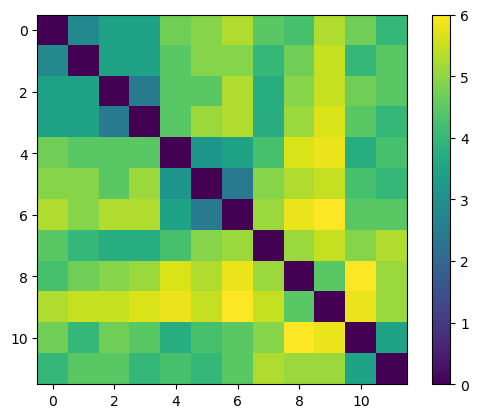

In [45]:
plt.imshow(S)
plt.colorbar()

<AxesSubplot:>

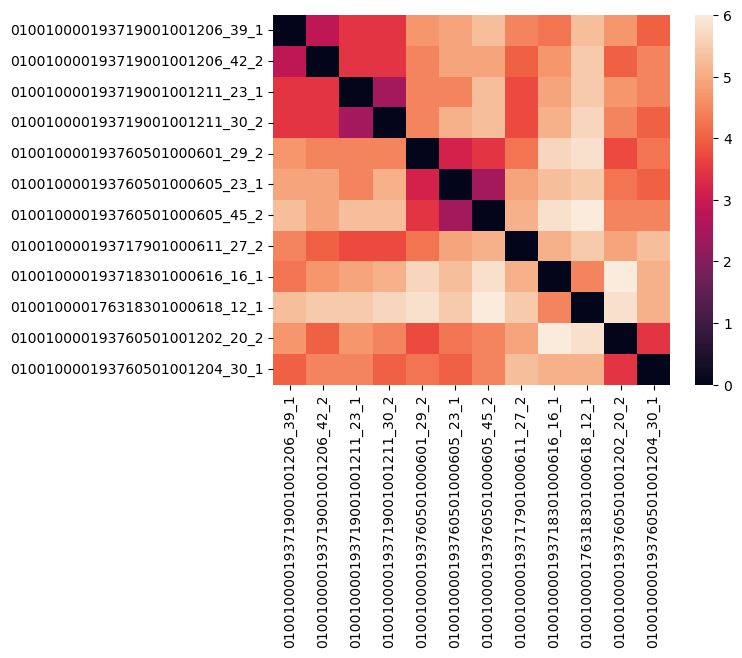

In [46]:
K = pd.DataFrame(S, index=L, columns=L)
sns.heatmap(K)